Epoch 0, Loss: 4710.982910, r: 0.000000
Epoch 500, Loss: 196.801407, r: -0.000005
Epoch 1000, Loss: 177.934464, r: -0.000927
Epoch 1500, Loss: 177.921341, r: -0.000001
Epoch 2000, Loss: 177.917236, r: 0.000544
Epoch 2500, Loss: 177.914001, r: -0.000000
Epoch 3000, Loss: 177.912506, r: 0.000042
Epoch 3500, Loss: 177.911591, r: 0.000000
Epoch 4000, Loss: 177.910965, r: -0.000000
Epoch 4500, Loss: 177.910522, r: 0.000058


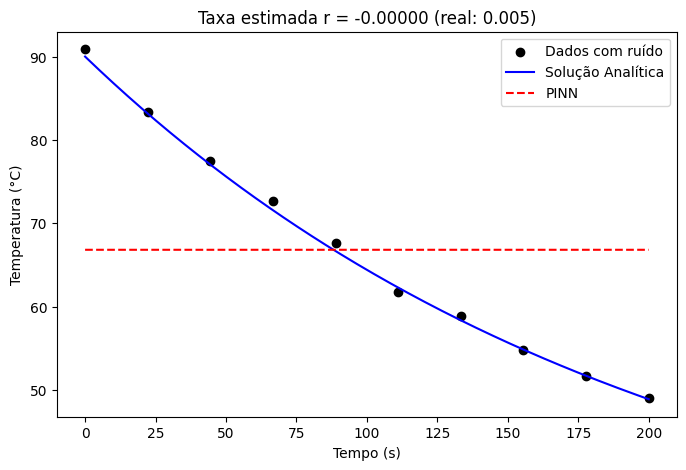

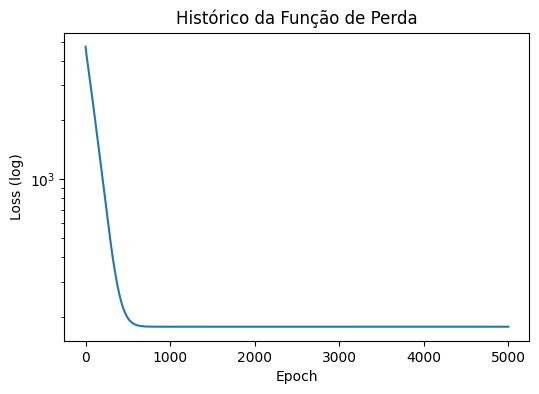

In [1]:
#Atividade 4_ Tutorial PINN

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np


# Definindo o dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parâmetros reais do problema
T_amb = 25.0  # °C
r_true = 0.005  # taxa de resfriamento real
T0 = 90.0  # temperatura inicial

# Gerando dados sintéticos com ruído
np.random.seed(0)
t_points = np.linspace(0, 200, 10)
T_points = T_amb + (T0 - T_amb) * np.exp(-r_true * t_points)
noise = np.random.normal(0, 0.5, size=T_points.shape)
T_noisy = T_points + noise

# Convertendo para tensores
t_train = torch.tensor(t_points, dtype=torch.float32).unsqueeze(1).to(device)
T_train = torch.tensor(T_noisy, dtype=torch.float32).unsqueeze(1).to(device)
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )
        # Inicializando r como parâmetro a ser aprendido
        self.r = nn.Parameter(torch.tensor(0.01))  # chute inicial

    def forward(self, t):
        return self.net(t)
def pinn_loss(model, t_data, T_data):
    # Predição da rede
    T_pred = model(t_data)

    # MSE entre dados e predição
    data_loss = nn.MSELoss()(T_pred, T_data)
    
    # Pontos para colocation (derivadas)
    t_col = torch.linspace(0, 200, 100).unsqueeze(1).to(device).requires_grad_(True)
    T_col = model(t_col)

    # Derivada dT/dt via autograd
    dT_dt = torch.autograd.grad(T_col, t_col, torch.ones_like(T_col), create_graph=True)[0]

    # Resíduo da EDO
    physics_residual = dT_dt - model.r * (T_amb - T_col)

    physics_loss = torch.mean(physics_residual**2)

    # Total loss: dados + física
    return data_loss + physics_loss
# Inicializando modelo
model = PINN().to(device)

# Otimizador
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Treinamento
n_epochs = 5000
loss_history = []

for epoch in range(n_epochs):
    optimizer.zero_grad()
    loss = pinn_loss(model, t_train, T_train)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.6f}, r: {model.r.item():.6f}')
# Predição
t_test = torch.linspace(0, 200, 200).unsqueeze(1).to(device)
T_pred = model(t_test).detach().cpu().numpy()

# Solução analítica
t_np = t_test.cpu().numpy().flatten()
T_analitica = T_amb + (T0 - T_amb) * np.exp(-r_true * t_np)

# Plot
plt.figure(figsize=(8,5))
plt.scatter(t_points, T_noisy, color='k', label='Dados com ruído')
plt.plot(t_np, T_analitica, 'b-', label='Solução Analítica')
plt.plot(t_np, T_pred, 'r--', label='PINN')
plt.xlabel('Tempo (s)')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.title(f'Taxa estimada r = {model.r.item():.5f} (real: {r_true})')
plt.show()
plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss (log)')
plt.title('Histórico da Função de Perda')
plt.show()
